* Kota Ajay Kumar
* 12040780
* References used for assignment
  * https://keras.io/api/layers/activations/ - for activation functions
  * https://www.analyticsvidhya.com/blog/2018/04/fundamentals-deep-learning-regularization-techniques/ - for regularization
  * https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/ - for Early stopping
  * https://keras.io/api/optimizers/ - optimizers

#PART 1

## Get Data and Cleaning

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#train data (which is too big so we take first 200000 rows from it)
train = pd.read_csv("/content/drive/MyDrive/colab files/ml-assignment1/part1/train.csv",nrows=200000)
#test data
test = pd.read_csv("/content/drive/MyDrive/colab files/ml-assignment1/part1/test.csv")

In [4]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [5]:
test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [6]:
#checking total null values
train.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [7]:
train.shape

(200000, 8)

In [8]:
#Lets drop the null values
train  = train.drop(train[train.isnull().any(1)].index, axis=0)

In [9]:
train.shape

(199999, 8)

In [10]:
#lets check if there is any negative values in fare amount column
train['fare_amount'].describe()

count    199999.000000
mean         11.342871
std           9.837879
min         -44.900000
25%           6.000000
50%           8.500000
75%          12.500000
max         500.000000
Name: fare_amount, dtype: float64

In [11]:
# lets drop the rows with fare amount less than 2.5 as 2.5 is least for a cab in nyc.
train = train[(train["fare_amount"] >= 2.5) &
          (train["fare_amount"] <
           train["fare_amount"].quantile(.9999))]
train.shape

(199956, 8)

In [12]:
train['fare_amount'].describe()

count    199956.000000
mean         11.323970
std           9.599686
min           2.500000
25%           6.000000
50%           8.500000
75%          12.500000
max         149.000000
Name: fare_amount, dtype: float64

In [13]:
train['passenger_count'].describe()
#happily the max is just 6 
#quite surprising that for some passenger count is zero

count    199956.000000
mean          1.682490
std           1.306768
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           6.000000
Name: passenger_count, dtype: float64

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199956 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                199956 non-null  object 
 1   fare_amount        199956 non-null  float64
 2   pickup_datetime    199956 non-null  object 
 3   pickup_longitude   199956 non-null  float64
 4   pickup_latitude    199956 non-null  float64
 5   dropoff_longitude  199956 non-null  float64
 6   dropoff_latitude   199956 non-null  float64
 7   passenger_count    199956 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 13.7+ MB


In [15]:
train['pickup_latitude'].describe()

count    199956.000000
mean         39.923159
std          10.048062
min       -3116.285383
25%          40.735010
50%          40.752762
75%          40.767125
max        1703.092772
Name: pickup_latitude, dtype: float64

In [16]:
#remove the rows with missing values
train=train.dropna(how = 'any', axis = 'rows')

In [17]:
train.shape

(199956, 8)

In [18]:
train['key'] = pd.to_datetime(train['key'])
test['key'] = pd.to_datetime(test['key'])
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])
# train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199956 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   key                199956 non-null  datetime64[ns]
 1   fare_amount        199956 non-null  float64       
 2   pickup_datetime    199956 non-null  object        
 3   pickup_longitude   199956 non-null  float64       
 4   pickup_latitude    199956 non-null  float64       
 5   dropoff_longitude  199956 non-null  float64       
 6   dropoff_latitude   199956 non-null  float64       
 7   passenger_count    199956 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 13.7+ MB


In [20]:
data = [train, test]
for i in data:
    i['Year'] = i['key'].dt.year
    i['Month'] = i['key'].dt.month
    i['Date'] = i['key'].dt.day
    i['Day_of_Week'] = i['key'].dt.dayofweek
    i['Hour'] = i['key'].dt.hour

In [21]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,Date,Day_of_Week,Hour
0,2009-06-15 17:26:21.000000100,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,0,17
1,2010-01-05 16:52:16.000000200,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,1,16
2,2011-08-18 00:35:00.000000490,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,3,0
3,2012-04-21 04:30:42.000000100,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,5,4
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,1,7


In [22]:
#calculating distance using haversine formula
# radius of earth in kilometers
R = 6373.0
coord = ['pickup_longitude', 'pickup_latitude',
         'dropoff_longitude', 'dropoff_latitude']
pickup_lat = np.radians(train["pickup_latitude"])
pickup_lon = np.radians(train["pickup_longitude"])
dropoff_lat = np.radians(train["dropoff_latitude"])
dropoff_lon = np.radians(train["dropoff_longitude"])

dist_lon = dropoff_lon - pickup_lon
dist_lat = dropoff_lat - pickup_lat

# Formula
a = (np.sin(dist_lat/2))**2 + np.cos(pickup_lat) * \
    np.cos(dropoff_lat) * (np.sin(dist_lon/2))**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
d = R * c  # (where R is the radius of the Earth)

train["trip_distance_km"] = d

train[coord + ["trip_distance_km"]].head(7)

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_distance_km
0,-73.844311,40.721319,-73.841610,40.712278,1.031088
1,-74.016048,40.711303,-73.979268,40.782004,8.452786
2,-73.982738,40.761270,-73.991242,40.750562,1.389961
3,-73.987130,40.733143,-73.991567,40.758092,2.800149
4,-73.968095,40.768008,-73.956655,40.783762,1.999784
5,-74.000964,40.731630,-73.972892,40.758233,3.788428
6,-73.980002,40.751662,-73.973802,40.764842,1.556295


In [23]:
#calculating distance using haversine formula
# radius of earth in kilometers
R = 6373.0
coord = ['pickup_longitude', 'pickup_latitude',
         'dropoff_longitude', 'dropoff_latitude']
pickup_lat = np.radians(test["pickup_latitude"])
pickup_lon = np.radians(test["pickup_longitude"])
dropoff_lat = np.radians(test["dropoff_latitude"])
dropoff_lon = np.radians(test["dropoff_longitude"])

dist_lon = dropoff_lon - pickup_lon
dist_lat = dropoff_lat - pickup_lat

# Formula
a = (np.sin(dist_lat/2))**2 + np.cos(pickup_lat) * \
    np.cos(dropoff_lat) * (np.sin(dist_lon/2))**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
d = R * c  # (where R is the radius of the Earth)

test["trip_distance_km"] = d

test[coord + ["trip_distance_km"]].head(7)

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_distance_km
0,-73.973320,40.763805,-73.981430,40.743835,2.323989
1,-73.986862,40.719383,-73.998886,40.739201,2.426114
2,-73.982524,40.751260,-73.979654,40.746139,0.618822
3,-73.981160,40.767807,-73.990448,40.751635,1.961648
4,-73.966046,40.789775,-73.988565,40.744427,5.388992
5,-73.960983,40.765547,-73.979177,40.740053,3.223561
6,-73.949013,40.773204,-73.959622,40.770893,0.929893


Text(0, 0.5, 'Fare')

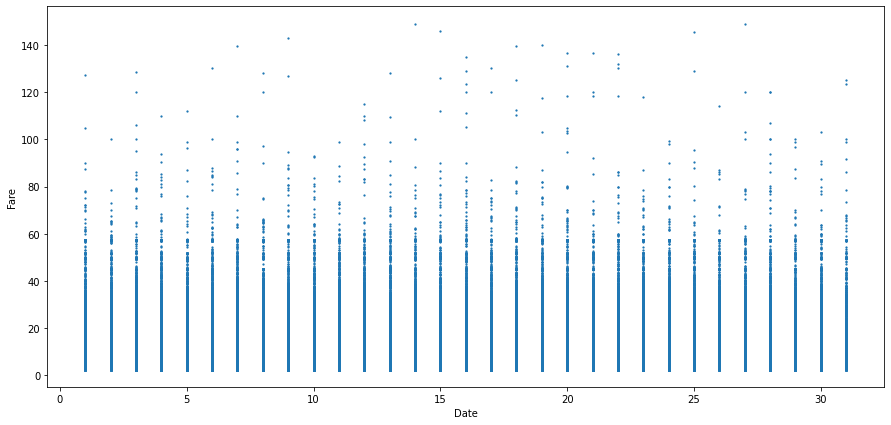

In [24]:
plt.figure(figsize=(15,7))
plt.scatter(x=train['Date'], y=train['fare_amount'], s=1.5)
plt.xlabel('Date')
plt.ylabel('Fare')
#fare is almost same for all days

Text(0, 0.5, 'Fare')

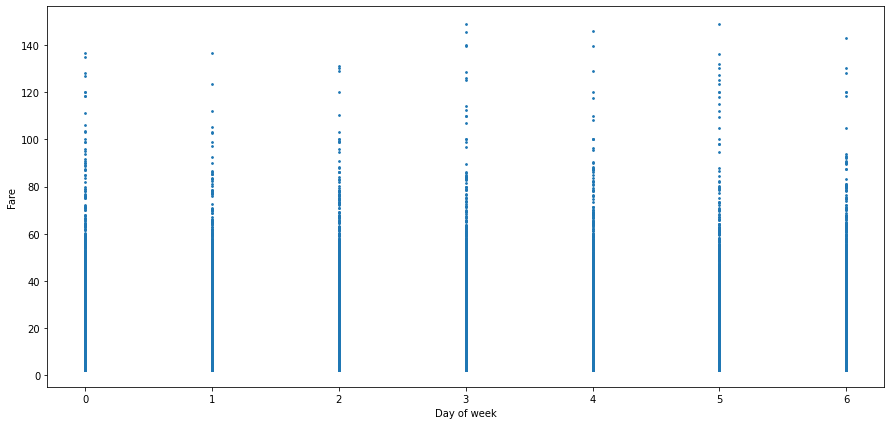

In [25]:
plt.figure(figsize=(15,7))
plt.scatter(x=train['Day_of_Week'], y=train['fare_amount'],s=3)
plt.xlabel('Day of week')
plt.ylabel('Fare')
#fare is most on wednesday but doesnt affect much

Text(0, 0.5, 'frequency')

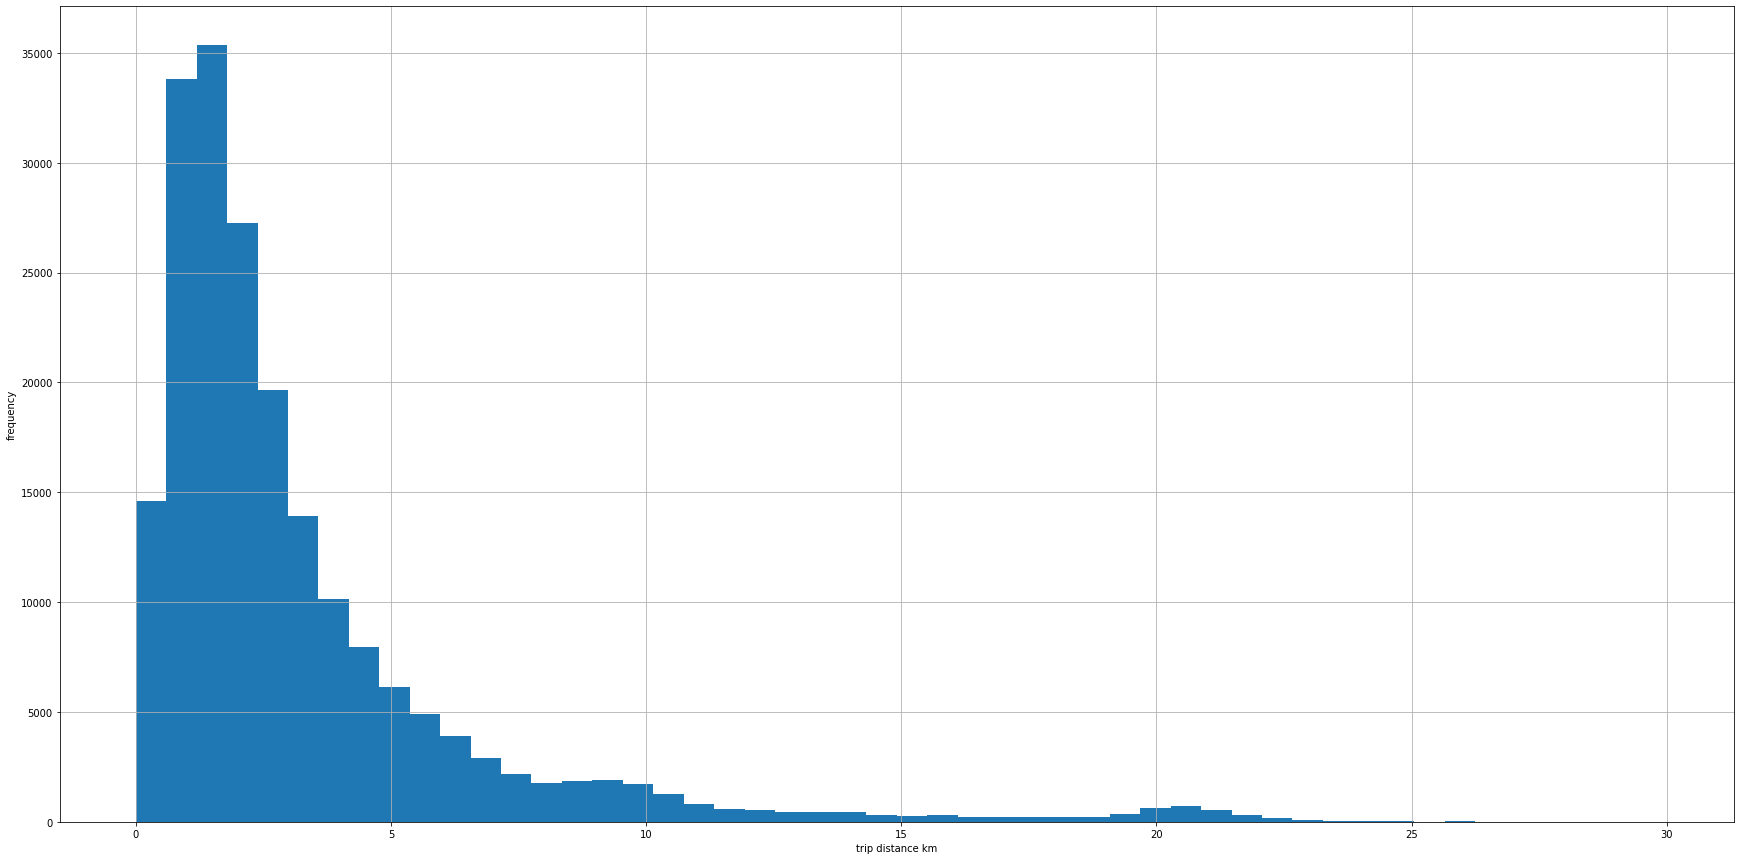

In [26]:
train[train.trip_distance_km<30].trip_distance_km.hist(bins=50,figsize=(30,15))
plt.xlabel('trip distance km')
plt.ylabel('frequency')
#most trips are around 3 km

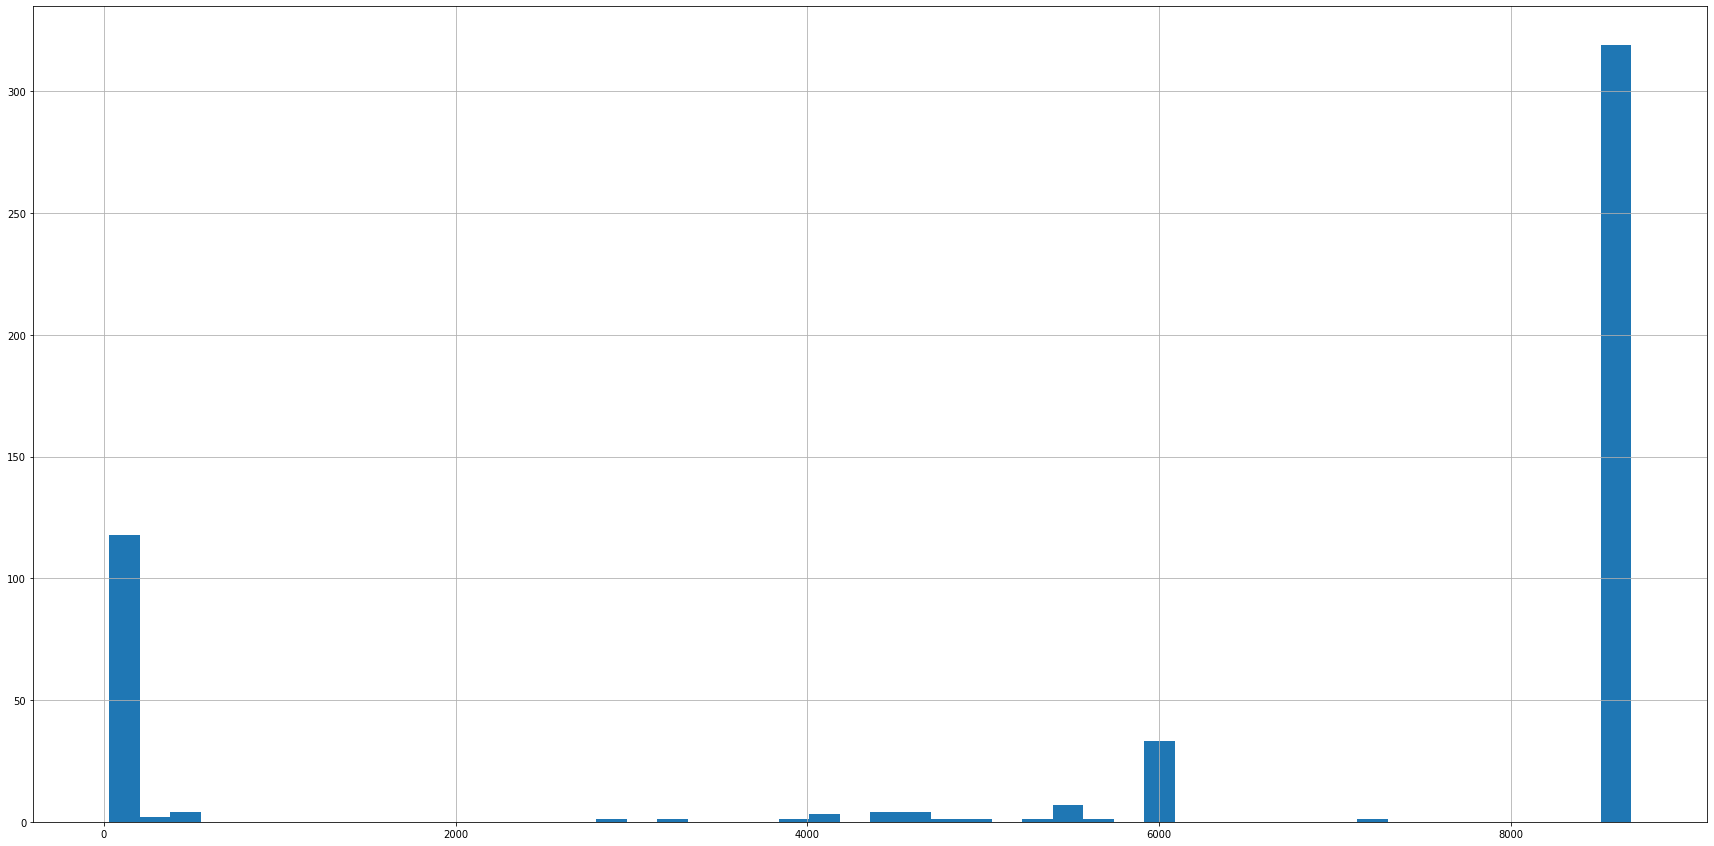

In [27]:
train[train.trip_distance_km>30].trip_distance_km.hist(bins=50,figsize=(30,15))
##there is not much distance travelled but there are some outliers

In [28]:
#Let's drop the values which are not possible as coordinates
train = train.drop(train[train['pickup_latitude']<-90].index, axis = 0)
train = train.drop(train[train['pickup_latitude']>90].index, axis = 0)

train = train.drop(train[train['pickup_longitude']<-180].index, axis = 0)
train = train.drop(train[train['pickup_longitude']>180].index, axis = 0)

train = train.drop(train[train['dropoff_latitude']<-90].index, axis = 0)
train = train.drop(train[train['dropoff_latitude']>90].index, axis = 0)

train = train.drop(train[train['dropoff_longitude']<-180].index, axis = 0)
train = train.drop(train[train['dropoff_longitude']>180].index, axis = 0)

In [29]:
train.shape

(199950, 14)

In [30]:
train['trip_distance_km'].describe()

count    199950.000000
mean         18.662841
std         357.980582
min           0.000000
25%           1.215872
50%           2.118639
75%           3.872272
max        8683.679606
Name: trip_distance_km, dtype: float64

In [31]:
df = train.drop(['key','pickup_datetime'],axis=1)

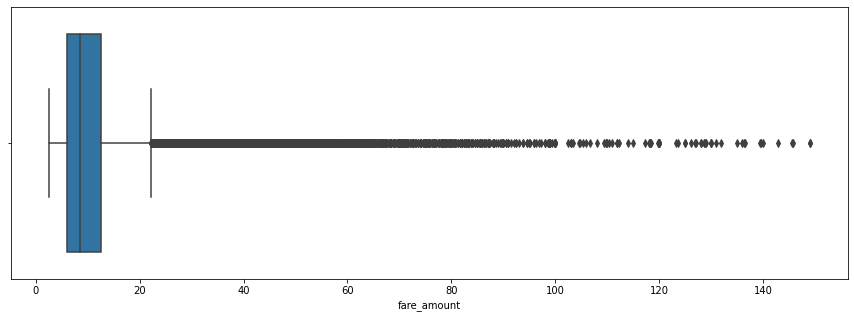

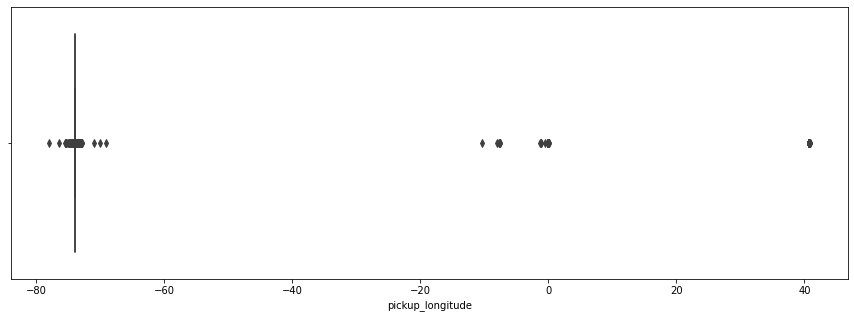

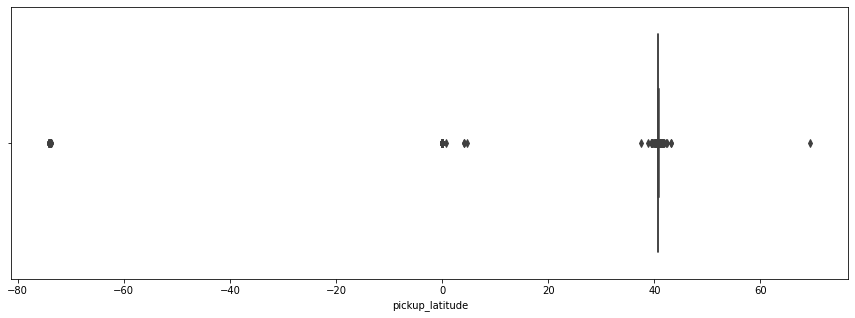

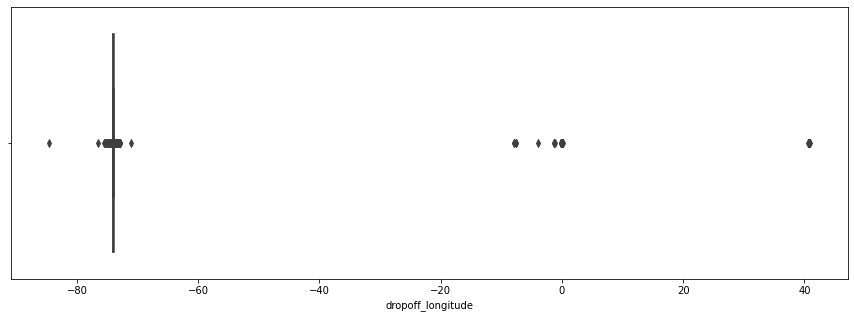

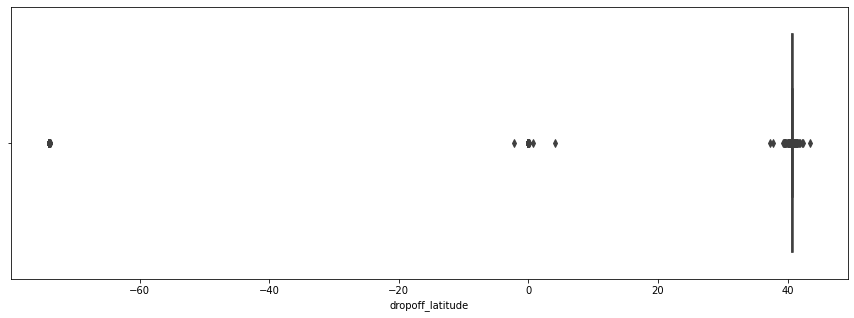

In [ ]:

list_columns=list(df.columns)
def boxplot(b):
  fig,ax=plt.subplots(figsize=(15,5))
  sns.boxplot(x=b,data=train)
  plt.xlabel(b)
  plt.show()
for i in list_columns:
  boxplot(i)

from above we can see that fare amount and trip distance have a lot of outliers so we will drop the outliers.

In [32]:
#Removing Outliers
diff = 12*(train['fare_amount'].quantile(0.9) - train['fare_amount'].quantile(0.1))
upper_value = df['fare_amount'].quantile(0.9)+diff
lower_value = df['fare_amount'].quantile(0.1)-diff
train = train[(train['fare_amount']<upper_value)&(train['fare_amount']>lower_value)]

diff = 12*(train['trip_distance_km'].quantile(0.9) -
           train['trip_distance_km'].quantile(0.1))
upper_value = df['trip_distance_km'].quantile(0.9)+diff
lower_value = df['trip_distance_km'].quantile(0.1)-diff
train = train[(train['trip_distance_km'] < upper_value) &
              (train['trip_distance_km'] > lower_value)]

In [36]:
test = test.drop(['key','pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],axis=1)

In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199502 entries, 0 to 199999
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   key                199502 non-null  datetime64[ns]
 1   fare_amount        199502 non-null  float64       
 2   pickup_datetime    199502 non-null  object        
 3   pickup_longitude   199502 non-null  float64       
 4   pickup_latitude    199502 non-null  float64       
 5   dropoff_longitude  199502 non-null  float64       
 6   dropoff_latitude   199502 non-null  float64       
 7   passenger_count    199502 non-null  int64         
 8   Year               199502 non-null  int64         
 9   Month              199502 non-null  int64         
 10  Date               199502 non-null  int64         
 11  Day_of_Week        199502 non-null  int64         
 12  Hour               199502 non-null  int64         
 13  trip_distance_km   199502 non-null  float64 

##A: Neural network

In [34]:
# Import required libraries
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [37]:
import numpy as np
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler

x, y = train.drop(['key', 'fare_amount', 'pickup_datetime','pickup_longitude', 'pickup_latitude',
         'dropoff_longitude', 'dropoff_latitude'], axis = 1), train['fare_amount']

from sklearn.preprocessing import StandardScaler
nor = StandardScaler()
# for i in x.columns:
#     a = np.array(x[i]).reshape(-1,1)
#     nor.fit(a)
#     x[i] = nor.transform(a).reshape(1,-1)[0]
x_s = nor.fit_transform(x)
test = nor.transform(test)

x_train, x_test, y_train, y_test = train_test_split(x_s, y, test_size=0.25, random_state=12)

In [38]:
x_train = tf.constant(x_train)
x_test = tf.constant(x_test)
y_train = tf.constant(y_train)
y_test = tf.constant(y_test)

In [39]:
# Build a neural network

tf.random.set_seed(42)

# 1. Create a model
model = tf.keras.Sequential([
                                       tf.keras.layers.Dense(16, activation='sigmoid'),
                                       tf.keras.layers.Dense(8, activation='sigmoid'),
                                       tf.keras.layers.Dense(1)
])
# 2. Compile the model
model.compile(loss = tf.keras.losses.mae,
                        optimizer = tf.keras.optimizers.SGD(learning_rate=0.01),
                        metrics = ["mae","mape","mse"]
                        )

# 3. Fitting the model
history = model.fit(x_train, y_train, epochs = 50,batch_size = 128)

Epoch 1/50
1169/1169 [==============================] - 3s 2ms/step - loss: 5.8425 - mae: 5.8425 - mape: 45.8772 - mse: 110.6135
Epoch 2/50
1169/1169 [==============================] - 2s 2ms/step - loss: 4.9844 - mae: 4.9844 - mape: 39.3222 - mse: 91.1625
Epoch 3/50
1169/1169 [==============================] - 2s 2ms/step - loss: 3.7019 - mae: 3.7019 - mape: 26.4319 - mse: 66.0593
Epoch 4/50
1169/1169 [==============================] - 2s 2ms/step - loss: 3.0871 - mae: 3.0871 - mape: 21.7359 - mse: 50.9137
Epoch 5/50
1169/1169 [==============================] - 2s 2ms/step - loss: 2.9561 - mae: 2.9561 - mape: 21.7532 - mse: 45.3181
Epoch 6/50
1169/1169 [==============================] - 2s 2ms/step - loss: 2.8648 - mae: 2.8648 - mape: 21.7853 - mse: 41.5699
Epoch 7/50
1169/1169 [==============================] - 2s 2ms/step - loss: 2.7904 - mae: 2.7904 - mape: 21.6575 - mse: 38.8468
Epoch 8/50
1169/1169 [==============================] - 2s 2ms/step - loss: 2.7253 - mae: 2.7253 - mape

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                128       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 273
Trainable params: 273
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.evaluate(x_test,y_test)

1559/1559 [==============================] - 3s 2ms/step - loss: 2.1863 - mae: 2.1863 - mape: 18.6684 - mse: 24.2106


[2.1862690448760986,
 2.1862690448760986,
 18.668365478515625,
 24.210617065429688]

In [42]:
pred=model.predict(x_test)

In [43]:
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_percentage_error,mean_absolute_error
print("MAPE: ",mean_absolute_percentage_error(y_test,pred))
print("MAE: ",mean_absolute_error(y_test,pred))
print("MSE: ",mean_squared_error(y_test,pred))

MAPE:  0.1866839063760478
MAE:  2.1862680541626744
MSE:  24.2106039331356


In [44]:
M1 = [mean_absolute_percentage_error(y_test,pred),mean_absolute_error(y_test,pred),mean_squared_error(y_test,pred)]

In [45]:
M =[] # to append all errors in one list
M.append(M1)

##B: Layers and Neurons

In [46]:
# Build a neural network with 3 layers

tf.random.set_seed(42)

# 1. Create a model
model = tf.keras.Sequential([
                                       tf.keras.layers.Dense(32, activation='sigmoid'),
                                       tf.keras.layers.Dense(16, activation='sigmoid'),
                                       tf.keras.layers.Dense(8, activation='sigmoid'),
                                       tf.keras.layers.Dense(1)
])
# 2. Compile the model
model.compile(loss = tf.keras.losses.mae,
                        optimizer = tf.keras.optimizers.SGD(learning_rate=0.01),
                        metrics = ["mae","mape","mse"]
                        )

# 3. Fitting the model
history = model.fit(x_train, y_train, epochs = 50,batch_size = 128)

Epoch 1/50
1169/1169 [==============================] - 3s 2ms/step - loss: 5.7197 - mae: 5.7197 - mape: 45.0218 - mse: 108.2191
Epoch 2/50
1169/1169 [==============================] - 2s 2ms/step - loss: 5.3361 - mae: 5.3361 - mape: 43.4715 - mse: 98.9103
Epoch 3/50
1169/1169 [==============================] - 2s 2ms/step - loss: 5.2786 - mae: 5.2786 - mape: 42.7339 - mse: 97.5040
Epoch 4/50
1169/1169 [==============================] - 2s 2ms/step - loss: 4.8845 - mae: 4.8845 - mape: 38.5289 - mse: 88.4157
Epoch 5/50
1169/1169 [==============================] - 2s 2ms/step - loss: 3.4087 - mae: 3.4087 - mape: 24.5355 - mse: 58.7062
Epoch 6/50
1169/1169 [==============================] - 2s 2ms/step - loss: 3.0120 - mae: 3.0120 - mape: 22.2283 - mse: 46.7804
Epoch 7/50
1169/1169 [==============================] - 2s 2ms/step - loss: 2.8909 - mae: 2.8909 - mape: 22.1795 - mse: 41.9782
Epoch 8/50
1169/1169 [==============================] - 2s 2ms/step - loss: 2.7958 - mae: 2.7958 - mape

In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                256       
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 8)                 136       
                                                                 
 dense_6 (Dense)             (None, 1)                 9         
                                                                 
Total params: 929
Trainable params: 929
Non-trainable params: 0
_________________________________________________________________


In [48]:
model.evaluate(x_test,y_test)

1559/1559 [==============================] - 3s 2ms/step - loss: 2.1467 - mae: 2.1467 - mape: 18.2646 - mse: 23.8306


[2.1466901302337646, 2.1466901302337646, 18.264551162719727, 23.83064079284668]

In [49]:
pred=model.predict(x_test)

In [50]:
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_percentage_error,mean_absolute_error
print("MAPE: ",mean_absolute_percentage_error(y_test,pred))
print("MAE: ",mean_absolute_error(y_test,pred))
print("MSE: ",mean_squared_error(y_test,pred))

MAPE:  0.18264539853675882
MAE:  2.146690344330551
MSE:  23.830639380703868


In [51]:
M2 = [mean_absolute_percentage_error(y_test,pred),mean_absolute_error(y_test,pred),mean_squared_error(y_test,pred)]
M.append(M2)

In [52]:
# Build a neural network with 4 layers

tf.random.set_seed(42)

# 1. Create a model
model = tf.keras.Sequential([
                                       tf.keras.layers.Dense(32, activation='sigmoid'),
                                       tf.keras.layers.Dense(64, activation='sigmoid'),
                                       tf.keras.layers.Dense(16, activation='sigmoid'),
                                       tf.keras.layers.Dense(8, activation='sigmoid'),
                                       tf.keras.layers.Dense(1)
])
# 2. Compile the model
model.compile(loss = tf.keras.losses.mae,
                        optimizer = tf.keras.optimizers.SGD(learning_rate=0.01),
                        metrics = ["mae","mape","mse"]
                        )

# 3. Fitting the model
history = model.fit(x_train, y_train, epochs = 50,batch_size = 128)

Epoch 1/50
1169/1169 [==============================] - 3s 2ms/step - loss: 5.7372 - mae: 5.7372 - mape: 45.1450 - mse: 108.6557
Epoch 2/50
1169/1169 [==============================] - 3s 2ms/step - loss: 5.3614 - mae: 5.3614 - mape: 43.7727 - mse: 99.5916
Epoch 3/50
1169/1169 [==============================] - 3s 2ms/step - loss: 5.3598 - mae: 5.3598 - mape: 43.7636 - mse: 99.5364
Epoch 4/50
1169/1169 [==============================] - 3s 2ms/step - loss: 5.3576 - mae: 5.3576 - mape: 43.7169 - mse: 99.4940
Epoch 5/50
1169/1169 [==============================] - 3s 2ms/step - loss: 5.3541 - mae: 5.3541 - mape: 43.6941 - mse: 99.3770
Epoch 6/50
1169/1169 [==============================] - 3s 2ms/step - loss: 5.3476 - mae: 5.3476 - mape: 43.6097 - mse: 99.2074
Epoch 7/50
1169/1169 [==============================] - 3s 2ms/step - loss: 5.3340 - mae: 5.3340 - mape: 43.4336 - mse: 98.8528
Epoch 8/50
1169/1169 [==============================] - 3s 2ms/step - loss: 5.2983 - mae: 5.2983 - mape

In [53]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 32)                256       
                                                                 
 dense_8 (Dense)             (None, 64)                2112      
                                                                 
 dense_9 (Dense)             (None, 16)                1040      
                                                                 
 dense_10 (Dense)            (None, 8)                 136       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 3,553
Trainable params: 3,553
Non-trainable params: 0
_________________________________________________________________


In [54]:
model.evaluate(x_test,y_test)

1559/1559 [==============================] - 3s 2ms/step - loss: 2.1618 - mae: 2.1618 - mape: 18.2352 - mse: 24.0874


[2.161818265914917, 2.161818265914917, 18.23517417907715, 24.087371826171875]

In [55]:
pred=model.predict(x_test)

In [56]:
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_percentage_error,mean_absolute_error
print("MAPE: ",mean_absolute_percentage_error(y_test,pred))
print("MAE: ",mean_absolute_error(y_test,pred))
print("MSE: ",mean_squared_error(y_test,pred))

MAPE:  0.18235189424790307
MAE:  2.161817541811745
MSE:  24.087351900752086


In [57]:
M3 = [mean_absolute_percentage_error(y_test,pred),mean_absolute_error(y_test,pred),mean_squared_error(y_test,pred)]
M.append(M3)

##C: Activation functions

###relu

In [58]:
# Build a neural network with 4 layers

tf.random.set_seed(42)

# 1. Create a model
model = tf.keras.Sequential([
                                       tf.keras.layers.Dense(32, activation='relu'),
                                       tf.keras.layers.Dense(64, activation='relu'),
                                       tf.keras.layers.Dense(16, activation='relu'),
                                       tf.keras.layers.Dense(8, activation='relu'),
                                       tf.keras.layers.Dense(1)
])
# 2. Compile the model
model.compile(loss = tf.keras.losses.mae,
                        optimizer = tf.keras.optimizers.SGD(learning_rate=0.01),
                        metrics = ["mae","mape","mse"]
                        )

# 3. Fitting the model
history = model.fit(x_train, y_train, epochs = 50,batch_size = 128)

Epoch 1/50
1169/1169 [==============================] - 3s 2ms/step - loss: 2.7305 - mae: 2.7305 - mape: 23.7437 - mse: 33.5150
Epoch 2/50
1169/1169 [==============================] - 3s 2ms/step - loss: 2.2291 - mae: 2.2291 - mape: 19.1094 - mse: 24.6559
Epoch 3/50
1169/1169 [==============================] - 3s 2ms/step - loss: 2.2101 - mae: 2.2101 - mape: 18.9567 - mse: 24.4145
Epoch 4/50
1169/1169 [==============================] - 3s 2ms/step - loss: 2.1978 - mae: 2.1978 - mape: 18.8505 - mse: 24.2588
Epoch 5/50
1169/1169 [==============================] - 3s 2ms/step - loss: 2.1906 - mae: 2.1906 - mape: 18.7390 - mse: 24.2018
Epoch 6/50
1169/1169 [==============================] - 3s 2ms/step - loss: 2.1813 - mae: 2.1813 - mape: 18.6543 - mse: 24.1180
Epoch 7/50
1169/1169 [==============================] - 3s 2ms/step - loss: 2.1754 - mae: 2.1754 - mape: 18.6009 - mse: 24.1046
Epoch 8/50
1169/1169 [==============================] - 3s 2ms/step - loss: 2.1698 - mae: 2.1698 - mape:

In [59]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 32)                256       
                                                                 
 dense_13 (Dense)            (None, 64)                2112      
                                                                 
 dense_14 (Dense)            (None, 16)                1040      
                                                                 
 dense_15 (Dense)            (None, 8)                 136       
                                                                 
 dense_16 (Dense)            (None, 1)                 9         
                                                                 
Total params: 3,553
Trainable params: 3,553
Non-trainable params: 0
_________________________________________________________________


In [60]:
model.evaluate(x_test,y_test)

1559/1559 [==============================] - 3s 2ms/step - loss: 2.1057 - mae: 2.1057 - mape: 18.0258 - mse: 23.2283


[2.105726480484009, 2.105726480484009, 18.025768280029297, 23.22827911376953]

In [61]:
pred=model.predict(x_test)

In [62]:
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_percentage_error,mean_absolute_error
print("MAPE: ",mean_absolute_percentage_error(y_test,pred))
print("MAE: ",mean_absolute_error(y_test,pred))
print("MSE: ",mean_squared_error(y_test,pred))

MAPE:  0.1802575631761426
MAE:  2.1057251592724144
MSE:  23.228266746712745


In [63]:
M4 = [mean_absolute_percentage_error(y_test,pred),mean_absolute_error(y_test,pred),mean_squared_error(y_test,pred)]
M.append(M4)

###Softmax

In [64]:
# Build a neural network with 4 layers

tf.random.set_seed(42)

# 1. Create a model
model = tf.keras.Sequential([
                                       tf.keras.layers.Dense(32, activation='softmax'),
                                       tf.keras.layers.Dense(64, activation='softmax'),
                                       tf.keras.layers.Dense(16, activation='softmax'),
                                       tf.keras.layers.Dense(8, activation='softmax'),
                                       tf.keras.layers.Dense(1)
])
# 2. Compile the model
model.compile(loss = tf.keras.losses.mae,
                        optimizer = tf.keras.optimizers.SGD(learning_rate=0.01),
                        metrics = ["mae","mape","mse"]
                        )

# 3. Fitting the model
history = model.fit(x_train, y_train, epochs = 50,batch_size = 128)

Epoch 1/50
1169/1169 [==============================] - 4s 3ms/step - loss: 6.8514 - mae: 6.8514 - mape: 50.1130 - mse: 134.4851
Epoch 2/50
1169/1169 [==============================] - 3s 3ms/step - loss: 5.3725 - mae: 5.3725 - mape: 41.9710 - mse: 101.9235
Epoch 3/50
1169/1169 [==============================] - 3s 3ms/step - loss: 5.3649 - mae: 5.3649 - mape: 43.4040 - mse: 100.1100
Epoch 4/50
1169/1169 [==============================] - 3s 3ms/step - loss: 5.3634 - mae: 5.3634 - mape: 43.8435 - mse: 99.5977
Epoch 5/50
1169/1169 [==============================] - 3s 3ms/step - loss: 5.3634 - mae: 5.3634 - mape: 43.8479 - mse: 99.5933
Epoch 6/50
1169/1169 [==============================] - 4s 3ms/step - loss: 5.3634 - mae: 5.3634 - mape: 43.8486 - mse: 99.5925
Epoch 7/50
1169/1169 [==============================] - 3s 2ms/step - loss: 5.3634 - mae: 5.3634 - mape: 43.8483 - mse: 99.5924
Epoch 8/50
1169/1169 [==============================] - 3s 3ms/step - loss: 5.3634 - mae: 5.3634 - ma

In [65]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 32)                256       
                                                                 
 dense_18 (Dense)            (None, 64)                2112      
                                                                 
 dense_19 (Dense)            (None, 16)                1040      
                                                                 
 dense_20 (Dense)            (None, 8)                 136       
                                                                 
 dense_21 (Dense)            (None, 1)                 9         
                                                                 
Total params: 3,553
Trainable params: 3,553
Non-trainable params: 0
_________________________________________________________________


In [66]:
model.evaluate(x_test,y_test)

1559/1559 [==============================] - 3s 2ms/step - loss: 5.3753 - mae: 5.3753 - mape: 43.9709 - mse: 100.4820


[5.375333786010742, 5.375333786010742, 43.97090148925781, 100.48196411132812]

In [67]:
pred=model.predict(x_test)

In [68]:
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_percentage_error,mean_absolute_error
print("MAPE: ",mean_absolute_percentage_error(y_test,pred))
print("MAE: ",mean_absolute_error(y_test,pred))
print("MSE: ",mean_squared_error(y_test,pred))

MAPE:  0.4397091041064003
MAE:  5.375332331593546
MSE:  100.48200330798059


In [69]:
M5 = [mean_absolute_percentage_error(y_test,pred),mean_absolute_error(y_test,pred),mean_squared_error(y_test,pred)]
M.append(M5)

##D: Regularization techniques

###Early Stopping

In [70]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1,patience = 2)

In [71]:
# Build a neural network

tf.random.set_seed(42)

# 1. Create a model
model = tf.keras.Sequential([
                                       tf.keras.layers.Dense(16, activation='sigmoid'),
                                       tf.keras.layers.Dense(8, activation='sigmoid'),
                                       tf.keras.layers.Dense(1)
])
# 2. Compile the model
model.compile(loss = tf.keras.losses.mae,
                        optimizer = tf.keras.optimizers.SGD(learning_rate=0.01),
                        metrics = ["mae","mape","mse"]
                        )

# 3. Fitting the model
history = model.fit(x_train, y_train, epochs = 50,batch_size = 128,callbacks= [callback])

Epoch 1/50
1169/1169 [==============================] - 3s 2ms/step - loss: 5.8425 - mae: 5.8425 - mape: 45.8772 - mse: 110.6135
Epoch 2/50
1169/1169 [==============================] - 2s 2ms/step - loss: 4.9844 - mae: 4.9844 - mape: 39.3222 - mse: 91.1625
Epoch 3/50
1169/1169 [==============================] - 2s 2ms/step - loss: 3.7019 - mae: 3.7019 - mape: 26.4319 - mse: 66.0593
Epoch 4/50
1169/1169 [==============================] - 2s 2ms/step - loss: 3.0871 - mae: 3.0871 - mape: 21.7359 - mse: 50.9137
Epoch 5/50
1169/1169 [==============================] - 2s 2ms/step - loss: 2.9561 - mae: 2.9561 - mape: 21.7532 - mse: 45.3181
Epoch 6/50
1169/1169 [==============================] - 2s 2ms/step - loss: 2.8648 - mae: 2.8648 - mape: 21.7853 - mse: 41.5699
Epoch 7/50
1169/1169 [==============================] - 2s 2ms/step - loss: 2.7904 - mae: 2.7904 - mape: 21.6575 - mse: 38.8468
Epoch 8/50
1169/1169 [==============================] - 2s 2ms/step - loss: 2.7253 - mae: 2.7253 - mape

In [72]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 16)                128       
                                                                 
 dense_23 (Dense)            (None, 8)                 136       
                                                                 
 dense_24 (Dense)            (None, 1)                 9         
                                                                 
Total params: 273
Trainable params: 273
Non-trainable params: 0
_________________________________________________________________


In [73]:
model.evaluate(x_test,y_test)

1559/1559 [==============================] - 3s 2ms/step - loss: 2.1863 - mae: 2.1863 - mape: 18.6684 - mse: 24.2106


[2.1862690448760986,
 2.1862690448760986,
 18.668365478515625,
 24.210617065429688]

In [74]:
pred=model.predict(x_test)

In [75]:
print("MAPE: ",mean_absolute_percentage_error(y_test,pred))
print("MAE: ",mean_absolute_error(y_test,pred))
print("MSE: ",mean_squared_error(y_test,pred))

MAPE:  0.1866839063760478
MAE:  2.1862680541626744
MSE:  24.2106039331356


In [76]:
M6 = [mean_absolute_percentage_error(y_test,pred),mean_absolute_error(y_test,pred),mean_squared_error(y_test,pred)]
M.append(M6)

###dropout rate

In [77]:
# Build a neural network

tf.random.set_seed(42)

# 1. Create a model
model = tf.keras.Sequential([
                                       tf.keras.layers.Dense(16, activation='sigmoid'),tf.keras.layers.Dropout(0.5),
                                       tf.keras.layers.Dense(8, activation='sigmoid'),tf.keras.layers.Dropout(0.5),
                                       tf.keras.layers.Dense(1)
])
# 2. Compile the model
model.compile(loss = tf.keras.losses.mae,
                        optimizer = tf.keras.optimizers.SGD(learning_rate=0.01),
                        metrics = ["mae","mape","mse"]
                        )

# 3. Fitting the model
history = model.fit(x_train, y_train, epochs = 50,batch_size = 128)

Epoch 1/50
1169/1169 [==============================] - 3s 2ms/step - loss: 6.3354 - mae: 6.3354 - mape: 50.6084 - mse: 118.6775
Epoch 2/50
1169/1169 [==============================] - 3s 2ms/step - loss: 5.5025 - mae: 5.5025 - mape: 44.1771 - mse: 100.8738
Epoch 3/50
1169/1169 [==============================] - 3s 2ms/step - loss: 5.2242 - mae: 5.2242 - mape: 42.0783 - mse: 93.9133
Epoch 4/50
1169/1169 [==============================] - 3s 2ms/step - loss: 4.8277 - mae: 4.8277 - mape: 39.1867 - mse: 83.4713
Epoch 5/50
1169/1169 [==============================] - 4s 3ms/step - loss: 4.3915 - mae: 4.3915 - mape: 35.9548 - mse: 71.7598
Epoch 6/50
1169/1169 [==============================] - 2s 2ms/step - loss: 4.0721 - mae: 4.0721 - mape: 33.4857 - mse: 63.1313
Epoch 7/50
1169/1169 [==============================] - 3s 2ms/step - loss: 3.9170 - mae: 3.9170 - mape: 32.4433 - mse: 58.6570
Epoch 8/50
1169/1169 [==============================] - 3s 2ms/step - loss: 3.8171 - mae: 3.8171 - map

In [78]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 16)                128       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_26 (Dense)            (None, 8)                 136       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_27 (Dense)            (None, 1)                 9         
                                                                 
Total params: 273
Trainable params: 273
Non-trainable params: 0
_________________________________________________________________


In [79]:
model.evaluate(x_test,y_test)

1559/1559 [==============================] - 3s 2ms/step - loss: 2.5389 - mae: 2.5389 - mape: 22.4721 - mse: 27.7003


[2.538926124572754, 2.538926124572754, 22.47212791442871, 27.700334548950195]

In [80]:
pred=model.predict(x_test)

In [81]:
print("MAPE: ",mean_absolute_percentage_error(y_test,pred))
print("MAE: ",mean_absolute_error(y_test,pred))
print("MSE: ",mean_squared_error(y_test,pred))

MAPE:  0.22472120450780256
MAE:  2.5389262725685673
MSE:  27.700360267577977


In [82]:
M7 = [mean_absolute_percentage_error(y_test,pred),mean_absolute_error(y_test,pred),mean_squared_error(y_test,pred)]
M.append(M7)

In [83]:
M

[[0.1866839063760478, 2.1862680541626744, 24.2106039331356],
 [0.18264539853675882, 2.146690344330551, 23.830639380703868],
 [0.18235189424790307, 2.161817541811745, 24.087351900752086],
 [0.1802575631761426, 2.1057251592724144, 23.228266746712745],
 [0.4397091041064003, 5.375332331593546, 100.48200330798059],
 [0.1866839063760478, 2.1862680541626744, 24.2106039331356],
 [0.22472120450780256, 2.5389262725685673, 27.700360267577977]]

In [84]:
# Build a neural network

tf.random.set_seed(42)

# 1. Create a model
model = tf.keras.Sequential([
                                       tf.keras.layers.Dense(16, activation='sigmoid'),tf.keras.layers.Dropout(0.2),
                                       tf.keras.layers.Dense(8, activation='sigmoid'),tf.keras.layers.Dropout(0.2),
                                       tf.keras.layers.Dense(1)
])
# 2. Compile the model
model.compile(loss = tf.keras.losses.mae,
                        optimizer = tf.keras.optimizers.SGD(learning_rate=0.01),
                        metrics = ["mae","mape","mse"]
                        )

# 3. Fitting the model
history = model.fit(x_train, y_train, epochs = 50,batch_size = 128)

Epoch 1/50
1169/1169 [==============================] - 3s 2ms/step - loss: 6.0183 - mae: 6.0183 - mape: 47.6828 - mse: 113.1616
Epoch 2/50
1169/1169 [==============================] - 3s 2ms/step - loss: 5.2541 - mae: 5.2541 - mape: 42.1639 - mse: 95.5929
Epoch 3/50
1169/1169 [==============================] - 3s 2ms/step - loss: 4.5122 - mae: 4.5122 - mape: 35.3963 - mse: 78.4796
Epoch 4/50
1169/1169 [==============================] - 3s 2ms/step - loss: 3.7507 - mae: 3.7507 - mape: 29.2898 - mse: 59.9693
Epoch 5/50
1169/1169 [==============================] - 3s 2ms/step - loss: 3.5006 - mae: 3.5006 - mape: 27.8764 - mse: 52.3290
Epoch 6/50
1169/1169 [==============================] - 3s 2ms/step - loss: 3.3827 - mae: 3.3827 - mape: 27.4390 - mse: 48.1963
Epoch 7/50
1169/1169 [==============================] - 3s 2ms/step - loss: 3.3110 - mae: 3.3110 - mape: 27.2479 - mse: 45.4185
Epoch 8/50
1169/1169 [==============================] - 2s 2ms/step - loss: 3.2452 - mae: 3.2452 - mape

In [85]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 16)                128       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_29 (Dense)            (None, 8)                 136       
                                                                 
 dropout_3 (Dropout)         (None, 8)                 0         
                                                                 
 dense_30 (Dense)            (None, 1)                 9         
                                                                 
Total params: 273
Trainable params: 273
Non-trainable params: 0
_________________________________________________________________


In [86]:
model.evaluate(x_test,y_test)

1559/1559 [==============================] - 3s 2ms/step - loss: 2.3002 - mae: 2.3002 - mape: 20.0981 - mse: 24.9015


[2.300171375274658, 2.300171375274658, 20.09807014465332, 24.90146827697754]

In [87]:
pred=model.predict(x_test)

In [88]:
print("MAPE: ",mean_absolute_percentage_error(y_test,pred))
print("MAE: ",mean_absolute_error(y_test,pred))
print("MSE: ",mean_squared_error(y_test,pred))

MAPE:  0.20098077882901572
MAE:  2.3001717193331843
MSE:  24.90147875115093


In [89]:
M8 = [mean_absolute_percentage_error(y_test,pred),mean_absolute_error(y_test,pred),mean_squared_error(y_test,pred)]
M.append(M8)

##E: Optimizers

###Adam optimizer

In [90]:
# Build a neural network

tf.random.set_seed(42)

# 1. Create a model
model = tf.keras.Sequential([
                                       tf.keras.layers.Dense(16, activation='sigmoid'),
                                       tf.keras.layers.Dense(8, activation='sigmoid'),
                                       tf.keras.layers.Dense(1)
])
# 2. Compile the model
model.compile(loss = tf.keras.losses.mae,
                        optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
                        metrics = ["mae","mape","mse"]
                        )

# 3. Fitting the model
history = model.fit(x_train, y_train, epochs = 50,batch_size = 128)

Epoch 1/50
1169/1169 [==============================] - 3s 2ms/step - loss: 3.9896 - mae: 3.9896 - mape: 27.7175 - mse: 73.4229
Epoch 2/50
1169/1169 [==============================] - 2s 2ms/step - loss: 2.5944 - mae: 2.5944 - mape: 19.7428 - mse: 34.6534
Epoch 3/50
1169/1169 [==============================] - 2s 2ms/step - loss: 2.3856 - mae: 2.3856 - mape: 19.3298 - mse: 27.3039
Epoch 4/50
1169/1169 [==============================] - 2s 2ms/step - loss: 2.2724 - mae: 2.2724 - mape: 19.1623 - mse: 24.7977
Epoch 5/50
1169/1169 [==============================] - 2s 2ms/step - loss: 2.2420 - mae: 2.2420 - mape: 19.0343 - mse: 24.3689
Epoch 6/50
1169/1169 [==============================] - 2s 2ms/step - loss: 2.2058 - mae: 2.2058 - mape: 18.9052 - mse: 23.8580
Epoch 7/50
1169/1169 [==============================] - 2s 2ms/step - loss: 2.1747 - mae: 2.1747 - mape: 18.8278 - mse: 23.2869
Epoch 8/50
1169/1169 [==============================] - 2s 2ms/step - loss: 2.1522 - mae: 2.1522 - mape:

In [91]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (None, 16)                128       
                                                                 
 dense_32 (Dense)            (None, 8)                 136       
                                                                 
 dense_33 (Dense)            (None, 1)                 9         
                                                                 
Total params: 273
Trainable params: 273
Non-trainable params: 0
_________________________________________________________________


In [92]:
model.evaluate(x_test,y_test)

1559/1559 [==============================] - 3s 2ms/step - loss: 2.0595 - mae: 2.0595 - mape: 18.0603 - mse: 22.3911


[2.0595481395721436, 2.0595481395721436, 18.060348510742188, 22.39114761352539]

In [93]:
pred=model.predict(x_test)

In [94]:
print("MAPE: ",mean_absolute_percentage_error(y_test,pred))
print("MAE: ",mean_absolute_error(y_test,pred))
print("MSE: ",mean_squared_error(y_test,pred))

MAPE:  0.18060356631057936
MAE:  2.059547945255552
MSE:  22.39115159029799


In [95]:
M9 = [mean_absolute_percentage_error(y_test,pred),mean_absolute_error(y_test,pred),mean_squared_error(y_test,pred)]
M.append(M9)

###Adamax optimizer

In [96]:
# Build a neural network

tf.random.set_seed(42)

# 1. Create a model
model = tf.keras.Sequential([
                                       tf.keras.layers.Dense(16, activation='sigmoid'),
                                       tf.keras.layers.Dense(8, activation='sigmoid'),
                                       tf.keras.layers.Dense(1)
])
# 2. Compile the model
model.compile(loss = tf.keras.losses.mae,
                        optimizer = tf.keras.optimizers.Adamax(learning_rate=0.01),
                        metrics = ["mae","mape","mse"]
                        )

# 3. Fitting the model
history = model.fit(x_train, y_train, epochs = 50,batch_size = 128)

Epoch 1/50
1169/1169 [==============================] - 3s 2ms/step - loss: 4.4535 - mae: 4.4535 - mape: 31.1731 - mse: 84.4764
Epoch 2/50
1169/1169 [==============================] - 2s 2ms/step - loss: 2.7400 - mae: 2.7400 - mape: 20.1169 - mse: 40.0467
Epoch 3/50
1169/1169 [==============================] - 2s 2ms/step - loss: 2.4459 - mae: 2.4459 - mape: 19.4710 - mse: 29.0457
Epoch 4/50
1169/1169 [==============================] - 2s 2ms/step - loss: 2.3155 - mae: 2.3155 - mape: 19.1835 - mse: 25.6104
Epoch 5/50
1169/1169 [==============================] - 2s 2ms/step - loss: 2.2634 - mae: 2.2634 - mape: 19.0798 - mse: 24.6833
Epoch 6/50
1169/1169 [==============================] - 3s 2ms/step - loss: 2.2545 - mae: 2.2545 - mape: 19.0711 - mse: 24.5184
Epoch 7/50
1169/1169 [==============================] - 2s 2ms/step - loss: 2.2489 - mae: 2.2489 - mape: 19.0517 - mse: 24.4645
Epoch 8/50
1169/1169 [==============================] - 2s 2ms/step - loss: 2.2451 - mae: 2.2451 - mape:

In [97]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 16)                128       
                                                                 
 dense_35 (Dense)            (None, 8)                 136       
                                                                 
 dense_36 (Dense)            (None, 1)                 9         
                                                                 
Total params: 273
Trainable params: 273
Non-trainable params: 0
_________________________________________________________________


In [98]:
model.evaluate(x_test,y_test)

1559/1559 [==============================] - 3s 2ms/step - loss: 2.1090 - mae: 2.1090 - mape: 18.2561 - mse: 23.3996


[2.109041452407837, 2.109041452407837, 18.256141662597656, 23.39958381652832]

In [99]:
pred=model.predict(x_test)

In [100]:
print("MAPE: ",mean_absolute_percentage_error(y_test,pred))
print("MAE: ",mean_absolute_error(y_test,pred))
print("MSE: ",mean_squared_error(y_test,pred))

MAPE:  0.18256139673729818
MAE:  2.1090402729649504
MSE:  23.39958780904205


In [101]:
M11 = [mean_absolute_percentage_error(y_test,pred),mean_absolute_error(y_test,pred),mean_squared_error(y_test,pred)]
M.append(M11)

##Confidence Intervals

In [102]:
table = pd.DataFrame(M,columns=["MAPE","MAE","MSE"])

In [103]:
table

,MAPE,MAE,MSE
0,0.186684,2.186268,24.210604
1,0.182645,2.146690,23.830639
2,0.182352,2.161818,24.087352
3,0.180258,2.105725,23.228267
4,0.439709,5.375332,100.482003
5,0.186684,2.186268,24.210604
6,0.224721,2.538926,27.700360
7,0.200981,2.300172,24.901479
8,0.180604,2.059548,22.391152
9,0.182561,2.109040,23.399588


In [104]:
import numpy as np
import scipy.stats as st
ci = []
for i in table.columns:
  data=np.array(table[i].tolist())
  # create 95% confidence interval
  ci.append(st.t.interval(alpha=0.95, df=len(data)-1,
                loc=np.mean(data),
                scale=st.sem(data)))

In [105]:
ci

[(0.15732109261187788, 0.27211865122892137),
 (1.7919719839040749, 3.241985555187097),
 (14.562817472095045, 49.12559205200283)]

In [106]:
confidenceintervals=pd.DataFrame({"Min":[ci[0][0],ci[1][0],ci[2][0]],"Max":[ci[0][1],ci[1][1],ci[2][1]]},index=["MAPE",'MAE','MSE'])

In [107]:
confidenceintervals

,Min,Max
MAPE,0.157321,0.272119
MAE,1.791972,3.241986
MSE,14.562817,49.125592


In [108]:
#best model is with relu activation function

In [109]:
# Build a neural network with 4 layers

tf.random.set_seed(42)

# 1. Create a model
model = tf.keras.Sequential([
                                       tf.keras.layers.Dense(32, activation='relu'),
                                       tf.keras.layers.Dense(64, activation='relu'),
                                       tf.keras.layers.Dense(16, activation='relu'),
                                       tf.keras.layers.Dense(8, activation='relu'),
                                       tf.keras.layers.Dense(1)
])
# 2. Compile the model
model.compile(loss = tf.keras.losses.mae,
                        optimizer = tf.keras.optimizers.SGD(learning_rate=0.01),
                        metrics = ["mae","mape","mse"]
                        )

# 3. Fitting the model
history = model.fit(x_train, y_train, epochs = 50,batch_size = 128)

Epoch 1/50
1169/1169 [==============================] - 3s 2ms/step - loss: 2.7305 - mae: 2.7305 - mape: 23.7437 - mse: 33.5150
Epoch 2/50
1169/1169 [==============================] - 3s 2ms/step - loss: 2.2291 - mae: 2.2291 - mape: 19.1094 - mse: 24.6559
Epoch 3/50
1169/1169 [==============================] - 3s 2ms/step - loss: 2.2101 - mae: 2.2101 - mape: 18.9567 - mse: 24.4145
Epoch 4/50
1169/1169 [==============================] - 2s 2ms/step - loss: 2.1978 - mae: 2.1978 - mape: 18.8505 - mse: 24.2588
Epoch 5/50
1169/1169 [==============================] - 2s 2ms/step - loss: 2.1906 - mae: 2.1906 - mape: 18.7390 - mse: 24.2018
Epoch 6/50
1169/1169 [==============================] - 2s 2ms/step - loss: 2.1813 - mae: 2.1813 - mape: 18.6543 - mse: 24.1180
Epoch 7/50
1169/1169 [==============================] - 3s 2ms/step - loss: 2.1754 - mae: 2.1754 - mape: 18.6009 - mse: 24.1046
Epoch 8/50
1169/1169 [==============================] - 3s 2ms/step - loss: 2.1698 - mae: 2.1698 - mape:

In [111]:
predicted = model.predict(test)

In [112]:
df = pd.DataFrame(predicted)

In [113]:
df.to_csv('fare_price.csv')

In [114]:
df

,0
0,10.891207
1,11.189842
2,4.404061
3,8.675081
4,16.820322
...,...
9909,8.472621
9910,12.245282
9911,51.627861
9912,22.423315
